# Example of high-level interface

In [3]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Boilerplate code (to be absorbed in some form into SWYFT)

In [80]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBATCH = 128  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NMAXEPOCHS = 5
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

In [81]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [82]:
def gen_train_data(model, nsamples, zdim, mask = None):
    # Generate training data
    if mask is None:
        z = swyft.sample_hypercube(nsamples, zdim)
    else:
        z = swyft.sample_constrained_hypercube(nsamples, zdim, mask)
    
    xz = swyft.simulate_xz(model, z)
    dataset = Data(xz)
    
    return dataset

In [111]:
def get_net(combinations = None):
    pdim = 1 if combinations is None else len(combinations[0])
    net = swyft.Network(ydim = 3, pnum = NDIM, pdim = pdim).to(DEVICE)
    return net

In [123]:
def train(net, dataset, combinations = None):
    nvalid = 512
    ntrain = len(dataset) - nvalid
    dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [ntrain, nvalid])
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    # Train!

    train_loss, valid_loss = [], []
    for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
        print(f'LR Iter {i}', end="\r")
        tl, vl, sd = swyft.train(net, train_loader, valid_loader, early_stopping_patience = 20, lr = lr, max_epochs = NMAXEPOCHS, device=DEVICE, combinations = combinations)
        vl_minimum = min(vl)
        vl_min_idx = vl.index(vl_minimum)
        train_loss.append(tl[:vl_min_idx + 1])
        valid_loss.append(vl[:vl_min_idx + 1])
        net.load_state_dict(sd)

In [113]:
def posteriors(x0, net, dataset):
    x = torch.tensor(x0).float().to(DEVICE)
    z = torch.stack(swyft.get_z(dataset)).to(DEVICE)
    lnL = swyft.get_lnL(net, x, z.unsqueeze(-1))
    return z.cpu(), lnL.cpu()

## Toy generative model

In [114]:
def model(z, sigma = .03):
    T = np.array([[1, 1.], [0, 1.], [0, 1.]])
    n = np.random.randn(3)*sigma
    x = T.dot(z) + n
    return x

## Mock data generation

In [115]:
z0 = np.ones(2)*0.5
x0 = model(z0)
print(x0, z0)

[0.9780972  0.49797139 0.51166308] [0.5 0.5]


## Inference (round 1)

In [116]:
net = get_net()
dataset = gen_train_data(model, NSAMPLES, NDIM, mask = None)
train(net, dataset)

## Check posteriors

In [117]:
zgrid, lnLgrid = posteriors(x0, net, dataset)

100%|██████████| 47/47 [00:00<00:00, 625.48it/s]


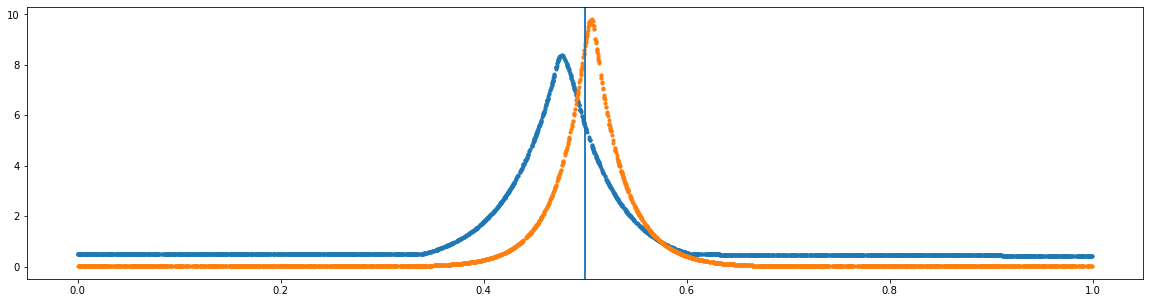

In [118]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    plt.axvline(z0[i])
    plt.scatter(zgrid[:,i], np.exp(lnLgrid[:,i]), marker='.')

## Infrence (round 2)

In [119]:
mask = swyft.Mask(net, torch.tensor(x0).float().to(DEVICE), 1e-1)
dataset2 = gen_train_data(model, NSAMPLES, NDIM, mask = mask)
net2 = get_net()
train(net2, dataset2)

100%|██████████| 47/47 [00:00<00:00, 662.87it/s]


Constrained posterior volume: 0.26966666666666667


## Check posteriors

In [120]:
zgrid, lnLgrid = posteriors(x0, net2, dataset2)

100%|██████████| 47/47 [00:00<00:00, 636.16it/s]


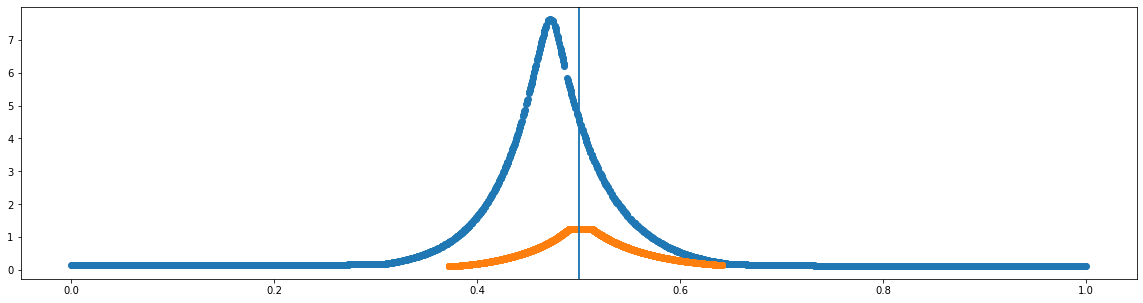

In [121]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    plt.axvline(z0[i])
    plt.scatter(zgrid[:,i], np.exp(lnLgrid[:,i]))

## Inference of 2-dim posteriors

In [127]:
combinations = [[0, 1], [0, 1]]
net3 = get_net(combinations = combinations)
train(net3, dataset2, combinations = combinations)

## Check 2-dim posteriors

In [131]:
#zgrid, lnLgrid = posteriors(x0, net3, dataset2)